# Sprint6課題 機械学習スクラッチ決定木

In [1]:
#サンプルデータ
import numpy as np
from sklearn.model_selection import train_test_split

np.random.seed(seed=0)
n_samples = 500
f0= [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

(X_train, X_val, y_train, y_val) = train_test_split(X, y, test_size=0.3)

## 【問題1】ジニ不純度を求める関数

$$
I(t) = 1-\sum_{i=1}^{K}P^2(C_i|t) = 1-\sum_{i=1}^{K}(\frac{N_{t,i}}{N_{t,all}})^{2}
$$

In [2]:
import numpy as np

def gini_impurity(X, y):
    #特徴量数
#     feature_num = X.shape[1]
    
    label_a, label_b = np.unique(y)
    # total_impurityを格納するarrayを作成
    total_impurity_list = np.array ([])
    
    for i in X[:1, 0]:
        #iを閾値としてover,underに分ける
        over_count, over_index = sum(X[:, 0] >= i), np.where(X[:, 0] >= i)[0]
        under_count, under_index = len(X) - over_count, np.where(X[:, 0] < i)[0]
        label_a_over, label_b_over  = np.sum(y[over_index] == label_a), np.sum(y[over_index] == label_b)
        label_a_under, label_b_under = np.sum(y[under_index] == label_a), np.sum(y[under_index] == label_b)

        impurity_over = 1 - ((label_a_over/over_count)**2+(label_b_over/over_count)**2)
        impurity_under = 1 - ((label_a_under/under_count)**2+(label_b_under/under_count)**2)

        total_impurity = (over_count/len(X))*(impurity_over) + (under_count/len(X))*(impurity_under)

    return total_impurity
gini_impurity(X, y)

0.1013963032430785

## 【問題2】情報利得を求める関数

$$
IG(p) = I(p)-\frac{N_{left,all}}{N_{p,all}}I(left)-\frac{N_{right,all}}{N_{p,all}}I(right)
$$

## 【問題3】深さ1の決定木分類器クラスの作成

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class ScratchDecesionTreeClassifier:
    """
    決定木を実行するClass
    """
    def __init__(self, criterion='gini', label_a=False, label_b=False, max_information_gain=False, threshold=False):
        self.criterion = criterion
        self.label_a = label_a
        self.label_b = label_b
        self.max_information_gain = max_information_gain
        self.threshold = threshold



    def _calculate_gini_impurity(self, label_a_count, label_b_count):
        """
        ジニ不純度を算出する関数
        """
        #入力されたラベル合計を算出
        total_label_count = label_a_count + label_b_count

        #ジニ不純度を算出
        total_impurity = 1 - (label_a_count/total_label_count)**2 - (label_b_count/total_label_count)**2

        return total_impurity


    def fit(self, X, y):
        self.label_a, self.label_b = np.unique(y)
        label_a_count, label_b_count = np.sum(y == self.label_a), np.sum(y == self.label_b)
        #親ノードのジニ不純度を算出
        ip = self._calculate_gini_impurity(label_a_count, label_b_count)

        information_gain_list = np.array([])

        for i in range(X.shape[1]):
            for j in X[:, i]:
                #iを閾値としてover,underの数とindex分ける
                over_count, over_index = sum(X[:, 0] >= j), np.where(X[:, 0] >= j)[0]
                under_count, under_index = len(X) - over_count, np.where(X[:, 0] < j)[0]

                #overとunderについて、ラベルごとの数をカウント
                label_a_over_count, label_b_over_count  = np.sum(y[over_index] == self.label_a), np.sum(y[over_index] == self.label_b)
                label_a_under_count, label_b_under_count = np.sum(y[under_index] == self.label_a), np.sum(y[under_index] == self.label_b)

                #over(左ノード)、under(右ノード)のジニ不純度を算出
                impurity_over = self._calculate_gini_impurity(label_a_over_count, label_b_over_count)
                impurity_under = self._calculate_gini_impurity(label_a_under_count, label_b_under_count)
                left = (over_count/(over_count+under_count)) * impurity_over
                right = (under_count/(over_count+under_count)) * impurity_under

                #情報利得を算出
                information_gain = ip - (left + right)

                #情報利得をarrayに追加, nanがある場合は0に置き換え
                information_gain_list = np.hstack([information_gain_list, information_gain])
                information_gain_list= np.where(information_gain_list != information_gain_list, 0, information_gain_list)

        #最大のinformation_gainを抽出
        self.max_information_gain= np.max(information_gain_list)
        
        #information_gainが最大の時の閾値を抽出
        self.threshold = X[np.argmax(information_gain_list)]


    def predict(self, X_predict):
        #閾値を基準にover,underに分ける
        predict_over_count, predict_over_index = sum(X_predict[:, 0] >= self.max_information_gain), np.where(X_predict[:, 0] >= self.max_information_gain)[0]
        predict_under_count, predict_under_index = len(X_predict) - predict_over_count, np.where(X_predict[:, 0] < self.max_information_gain)[0]

        #arrayを作成
        y_predict = np.zeros(len(X_predict))

        #over,underそれぞれにlabel_a,label_bを代入
        y_predict[predict_over_index] = self.label_a
        y_predict[predict_under_index] = self.label_b
        return y_predict

    def plot(self, X, y):
        plt.scatter(X[np.where(y==self.label_a)[0], 0], 
                    X[np.where(y==self.label_a)[0], 1], 
                    c='blue', label=self.label_a)
        plt.scatter(X[np.where(y==self.label_b)[0], 0],
                    X[np.where(y==self.label_b)[0], 1],
                    c='red', label=self.label_b)
        plt.plot([-5, 5], [self.threshold[0], self.threshold[0]], 'g')

        plt.legend()


In [17]:
sample_sdt = ScratchDecesionTreeClassifier()

In [18]:
sample_sdt.fit(X_train, y_train)

/Users/clouds_kimura/anaconda3/envs/pythonml/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in long_scalars


In [19]:
sample_sdt.predict(X_val)

array([-1.,  1., -1.,  1., -1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
        1., -1., -1., -1.,  1., -1., -1., -1.,  1., -1., -1., -1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,
        1., -1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1., -1., -1.,  1., -1.,
        1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,
       -1.,  1., -1., -1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1.,
        1., -1., -1.,  1., -1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,
        1., -1.,  1., -1.,  1.,  1., -1., -1., -1.,  1.,  1.,  1.,  1.,
        1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
       -1., -1., -1.,  1.,  1., -1., -1., -1., -1., -1.,  1.,  1.,  1.,
       -1., -1., -1.,  1.,  1., -1.,  1.])

## 【問題6】指標値の算出

In [22]:
from sklearn.metrics import accuracy_score

accuracy_score(y_val, sample_sdt.predict(X_val))

0.9266666666666666

## 【問題7】決定領域の可視化

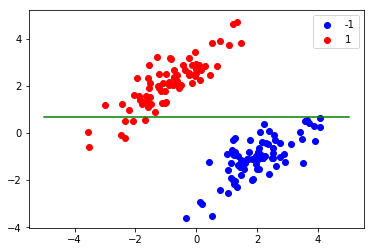

In [21]:
sample_sdt.plot(X_val, y_val)

## 【問題8】決定木の利用場面

前処理が少なくて良い  
解釈が比較的容易である。